In [2]:
# Configuration du chemin d'accès
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Configuration du chemin d'accès
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# PANDAS
import pandas as pd 
pd.set_option("display.max_rows", None, "display.max_columns", None) 

# WARNINGS
import warnings
warnings.filterwarnings('ignore')

# NUMPY
import numpy as np

# STATS
import scipy.stats as stats
from scipy.stats import norm, skew
import scipy as sp
from scipy.stats import chi2_contingency

# MATPLOTLIB
import matplotlib as mlp
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
%matplotlib inline

# PANDAS
import pandas as pd 
pd.set_option("display.max_rows", None, "display.max_columns", None) 

# SEABORN
import seaborn as sns

# SCIKIT-LEARN: MODELES
from sklearn.linear_model import LogisticRegression # Régression logistique
from sklearn.svm import SVC # Support Vector Classifier
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.ensemble import GradientBoostingClassifier # Gradient Boosting
from sklearn.ensemble import AdaBoostClassifier # AdaBoost
from sklearn.ensemble import BaggingClassifier # Bagging


# SCIKIT-LEARN: VALIDATION CROISEE + OPTIMISATION
from sklearn.model_selection import train_test_split # Séparer en données train et test
from sklearn.model_selection import cross_val_score # Validation croisée pour comparison entre modèles
from sklearn.model_selection import validation_curve # Courbe de validation : visulaisr des scores lors du choix d'un hyper-paramètre
from sklearn.model_selection import GridSearchCV # Tester plusieurs hyper-paramètres
from sklearn.model_selection import learning_curve # Courbe d'apprentissage : visualisation des scores du train et du validation sets en fonction des quanitiés des données
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

 ## YellowBrick
from yellowbrick.model_selection import LearningCurve
from yellowbrick.model_selection import ValidationCurve

## EVALUATION
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# SCHIKIT-LEARN: PIPELINE AND TRANSFORMATEURll
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

In [3]:
data = pd.read_csv('/kaggle/input/smoking-drinking-dataset/smoking_driking_dataset_Ver01.csv'
                   , nrows=100000
                )
df_smoking_drinking = data.copy()

In [4]:
def preprocess_data(data, target):
    X = data.drop(columns=[target])
    y = data[target]
    return X, y

def split_data(data, target, test_size=0.2, val_size=0.1):
    X, y = preprocess_data(data, target)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size + val_size, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size / (test_size + val_size), stratify=y_temp)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [5]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(df_smoking_drinking, 'SMK_stat_type_cd')

print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('X_test shape:', X_test.shape)

X_train shape: (69999, 23)
X_val shape: (10000, 23)
X_test shape: (20001, 23)


# Séparation variables continue/catégorielles

In [6]:
# Normalisation des variables continues
from sklearn.preprocessing import StandardScaler

cont_features = df_smoking_drinking.select_dtypes('float64').columns
cont_features = cont_features.drop('SMK_stat_type_cd')

cat_features = df_smoking_drinking.select_dtypes(include = ['int64', 'object']).columns
cat_features = cat_features.drop(['DRK_YN'])

In [7]:
def create_model_pipeline(cat_features, cont_features, model_class, **model_params):
    # Créer les pipelines pour les caractéristiques catégorielles et numériques
    categorical_pipeline = make_pipeline(
        SimpleImputer(strategy='most_frequent'),
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)  # Gérer les catégories inconnues
    )

    numeric_pipeline = make_pipeline(
        SimpleImputer(),
        StandardScaler()
    )

    # Créer le préprocesseur
    preprocessor_robust = make_column_transformer(
        (categorical_pipeline, cat_features),
        (numeric_pipeline, cont_features)
    )

    # Créer le pipeline avec le modèle spécifié et ses paramètres
    model_pipeline = make_pipeline(preprocessor_robust, model_class(**model_params))
    return model_pipeline


In [8]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    print('\n\n')
    print(f"--- Evaluation du modèle : {model_name} ---")

    # Entraînement du modèle
    model.fit(X_train, y_train)

    # Prédiction sur le jeu de test
    y_test_pred = model.predict(X_test)

    # Évaluation du modèle
    accuracy = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    print('Accuracy:', accuracy)
    print('F1:', f1)

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.title(f"Confusion Matrix for {model_name}")  # Add model name to the title
    disp.plot(ax=ax, values_format='d')  # Utiliser le format 'd' pour afficher les nombres entiers


    # Rapport de classification
    print(classification_report(y_test, y_test_pred))

    # Score du modèle
    score = model.score(X_test, y_test)
    print('Score :', score)
    
    return accuracy, f1, score

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from yellowbrick.model_selection import LearningCurve

def plot_learning_curve(pipeline, X_train, y_train, model_name="Model", cv=3, scoring='accuracy'):
    # Extract the last estimator from the pipeline
    model_step_name = list(pipeline.named_steps.keys())[-1]
    model = pipeline.named_steps[model_step_name]
    
    plt.figure()
    visualizer = LearningCurve(
        model,
        cv=cv,
        scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs=-1
    )
    visualizer.fit(pipeline[:-1].fit_transform(X_train, y_train), y_train)
    visualizer.finalize()
    visualizer.show(title=f"Learning Curve for {model_name}")
    plt.show()


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from yellowbrick.model_selection import ValidationCurve

def plot_validation_curve(pipeline, X_train, y_train, param_name, param_range, model_name="Model", cv=3, scoring='accuracy'):
    # Extract the last estimator from the pipeline
    model_step_name = list(pipeline.named_steps.keys())[-1]
    model = pipeline.named_steps[model_step_name]
    
    plt.figure()
    visualizer = ValidationCurve(
        model, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=-1
    )
    visualizer.fit(pipeline[:-1].fit_transform(X_train, y_train), y_train)
    visualizer.finalize()
    visualizer.show(title=f"Validation Curve for {model_name} with parameter {param_name}")
    plt.show()


## Apprentissage par ensemble - Pipeline

In [27]:
# Création du pipeline RandomForest
rf_pipeline = create_model_pipeline(
    cat_features, cont_features, RandomForestClassifier, random_state=42, class_weight='balanced')

# Création du pipeline GradientBoosting
gb_pipeline = create_model_pipeline(
    cat_features, cont_features, GradientBoostingClassifier, n_estimators=300, learning_rate=0.1, max_depth=3,random_state=42)





--- Evaluation du modèle : RandomForest ---
Accuracy: 0.6785660716964151
F1: 0.6997764771537723
              precision    recall  f1-score   support

         1.0       0.94      0.73      0.82     12112
         2.0       0.42      0.58      0.49      3551
         3.0       0.48      0.62      0.54      4338

    accuracy                           0.68     20001
   macro avg       0.61      0.64      0.61     20001
weighted avg       0.75      0.68      0.70     20001

Score : 0.6785660716964151



--- Evaluation du modèle : GradientBoosting ---
Accuracy: 0.7000649967501625
F1: 0.7012485169618449
              precision    recall  f1-score   support

         1.0       0.84      0.83      0.83     12112
         2.0       0.45      0.42      0.43      3551
         3.0       0.52      0.58      0.55      4338

    accuracy                           0.70     20001
   macro avg       0.60      0.61      0.61     20001
weighted avg       0.70      0.70      0.70     20001

Score : 0

(0.7000649967501625, 0.7012485169618449, 0.7000649967501625)

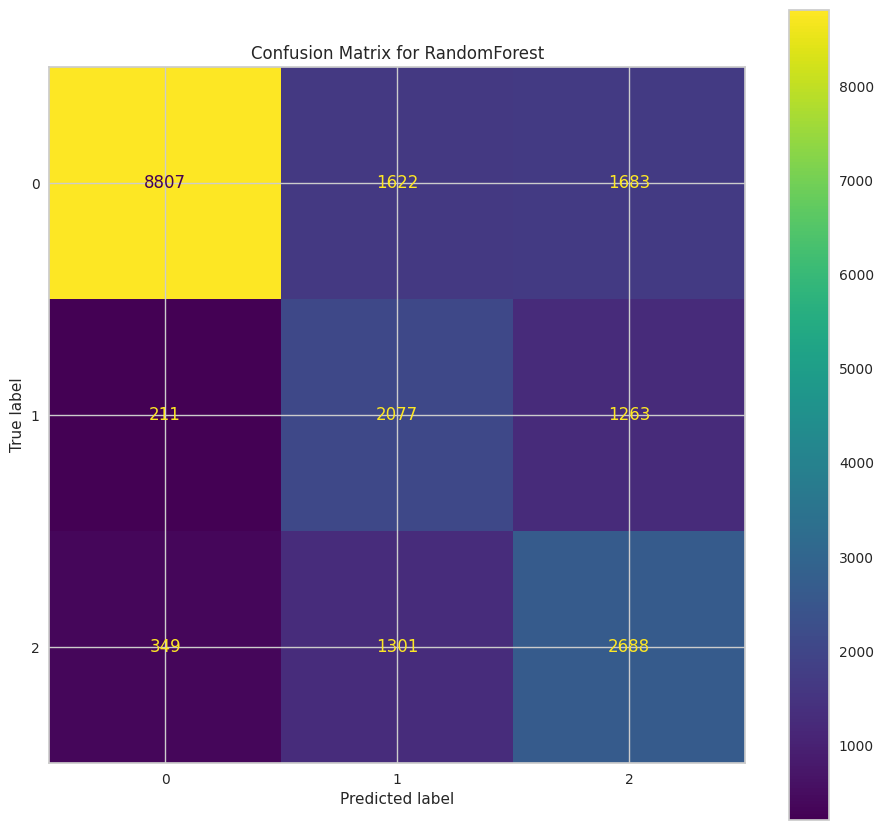

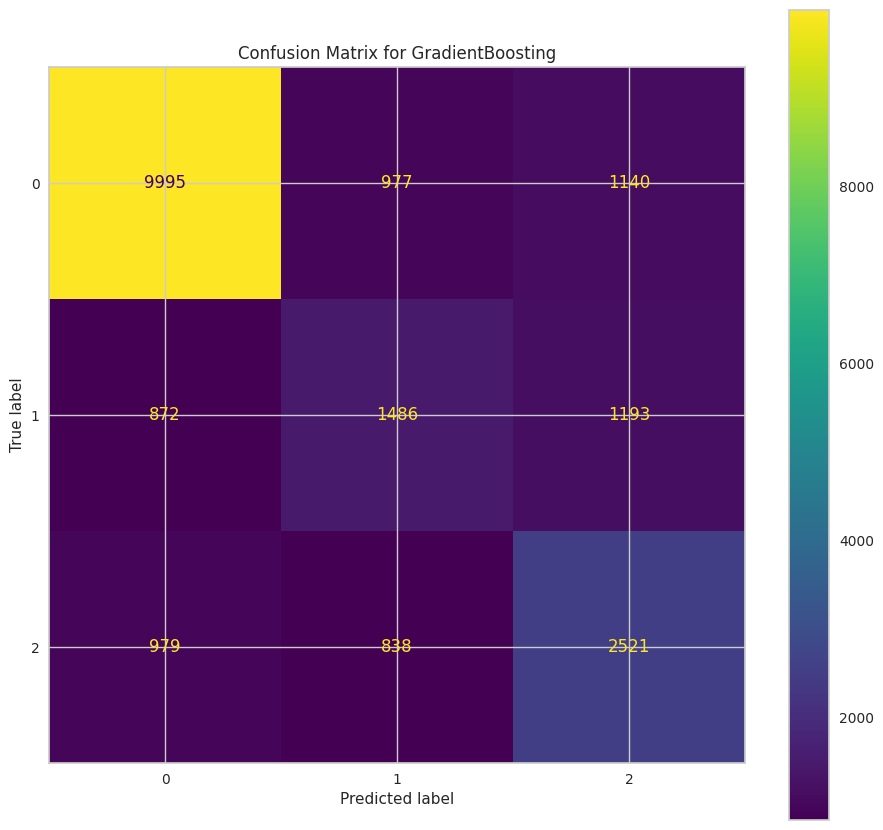

In [13]:
%%time
train_and_evaluate_model(rf_pipeline, X_train, y_train, X_test, y_test, model_name='RandomForest')
train_and_evaluate_model(gb_pipeline, X_train, y_train, X_test, y_test, model_name='GradientBoosting')

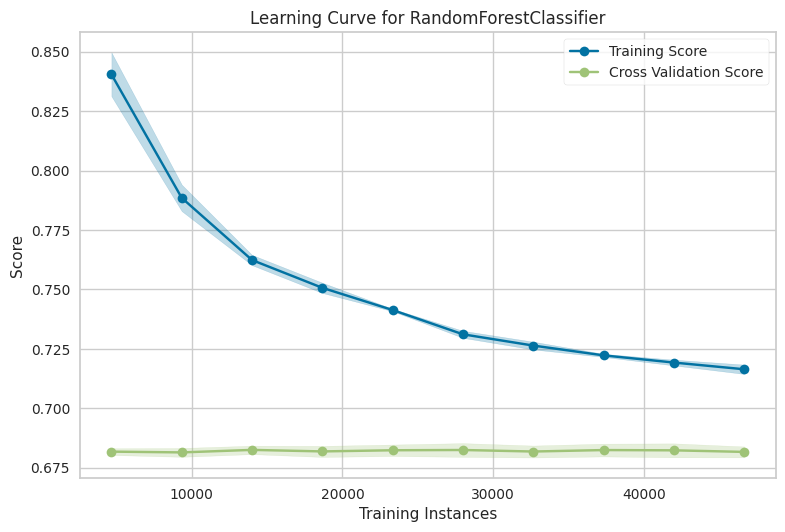

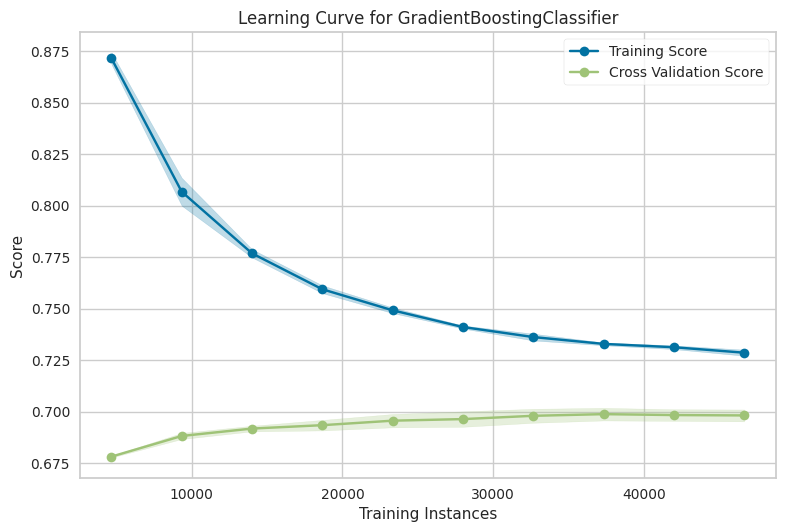

In [17]:
# Affichage de la courbe d'apprentissage
plot_learning_curve(rf_pipeline, X_train, y_train, model_name="RandomForest")
plot_learning_curve(gb_pipeline, X_train, y_train, model_name="GradientBoosting")


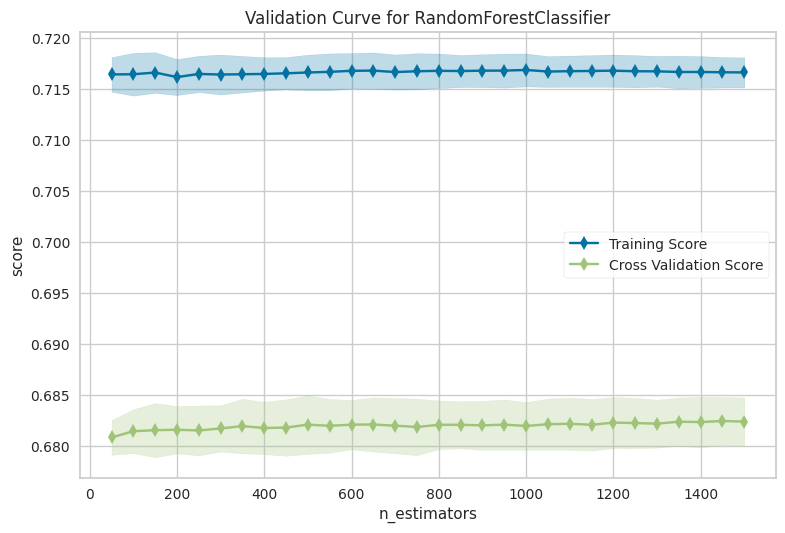

In [ ]:
# Affichage de la courbe de validation pour le paramètre 'n_estimators'
param_range_n_estimators = np.arange(50, 1501, 50)  # Valeurs pour n_estimators
plot_validation_curve(rf_pipeline, X_train, y_train, param_name='n_estimators', param_range=param_range_n_estimators, model_name="RandomForest")

In [ ]:
# Affichage de la courbe de validation pour le paramètre 'n_estimators'
param_range_n_estimators = np.arange(50, 1501, 50)  # Valeurs pour n_estimators
plot_validation_curve(gb_pipeline, X_train, y_train, param_name='n_estimators', param_range=param_range_n_estimators, model_name="GradientBoosting")


In [ ]:
import optuna
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

def hyperoptimize_gb_model(pipeline, X_train, y_train, X_test, y_test, n_trials=5, timeout=600):
    # Définissez la fonction objective pour Optuna
    def objective(trial):
        n_estimators = trial.suggest_int('gradientboostingclassifier__n_estimators',5, 2000)
        learning_rate = trial.suggest_loguniform('gradientboostingclassifier__learning_rate', 0.01, 0.3)
        max_depth = trial.suggest_int('gradientboostingclassifier__max_depth', 2, 32)
        min_samples_split = trial.suggest_int('gradientboostingclassifier__min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('gradientboostingclassifier__min_samples_leaf', 2, 10)
        
        pipeline.set_params(
            gradientboostingclassifier__n_estimators=n_estimators,
            gradientboostingclassifier__learning_rate=learning_rate,
            gradientboostingclassifier__max_depth=max_depth,
            gradientboostingclassifier__min_samples_split=min_samples_split,
            gradientboostingclassifier__min_samples_leaf=min_samples_leaf
        )

        # Apply the preprocessing steps except the last step
        X_train_transformed = pipeline[:-1].fit_transform(X_train, y_train)
        score = cross_val_score(pipeline.named_steps['gradientboostingclassifier'], X_train_transformed, y_train, cv=3, scoring='accuracy').mean()
        return score

    # Créez un objet study et optimisez la fonction objective
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, timeout=timeout)

    # Affichez les meilleurs hyperparamètres
    print('Best parameters:', study.best_params)

    # Entraînez le modèle avec les meilleurs hyperparamètres
    pipeline.set_params(**study.best_params)
    pipeline.fit(X_train, y_train)

    # Prédiction sur le jeu de test
    y_test_pred = pipeline.predict(X_test)

    # Évaluation du modèle
    accuracy = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    print('Accuracy on test set:', accuracy)
    print('F1 score on test set:', f1)

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, values_format='d')  # Utiliser le format 'd' pour afficher les nombres entiers
    plt.title("Confusion Matrix for GradientBoostingClassifier")
    plt.show()


    # Rapport de classification
    print(classification_report(y_test, y_test_pred))

    return study.best_params, accuracy, f1


In [ ]:
%%time
# Hyper-optimisation pour GradientBoosting
best_params_gb, accuracy_gb, f1_gb = hyperoptimize_gb_model(
    gb_pipeline, X_train, y_train, X_test, y_test, n_trials=5, timeout=600)

In [24]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

def hyperoptimize_rf_model(pipeline, X_train, y_train, X_test, y_test, n_trials=5, timeout=600):
    # Définissez la fonction objective pour Optuna
    def objective(trial):
        n_estimators = trial.suggest_int('randomforestclassifier__n_estimators', 50, 2000)
        max_depth = trial.suggest_int('randomforestclassifier__max_depth', 2, 32)
        min_samples_split = trial.suggest_int('randomforestclassifier__min_samples_split', 2, 15)
        min_samples_leaf = trial.suggest_int('randomforestclassifier__min_samples_leaf', 3, 10)
        
        pipeline.set_params(
            randomforestclassifier__n_estimators=n_estimators,
            randomforestclassifier__max_depth=max_depth,
            randomforestclassifier__min_samples_split=min_samples_split,
            randomforestclassifier__min_samples_leaf=min_samples_leaf
        )

        # Apply the preprocessing steps except the last step
        X_train_transformed = pipeline[:-1].fit_transform(X_train, y_train)
        score = cross_val_score(pipeline.named_steps['randomforestclassifier'], X_train_transformed, y_train, cv=3, scoring='accuracy').mean()
        return score

    # Créez un objet study et optimisez la fonction objective
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, timeout=timeout)

    # Affichez les meilleurs hyperparamètres
    print('Best parameters:', study.best_params)

    # Entraînez le modèle avec les meilleurs hyperparamètres
    pipeline.set_params(**study.best_params)
    pipeline.fit(X_train, y_train)

    # Prédiction sur le jeu de test
    y_test_pred = pipeline.predict(X_test)

    # Évaluation du modèle
    accuracy = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    print('Accuracy on test set:', accuracy)
    print('F1 score on test set:', f1)

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, values_format='d')  # Utiliser le format 'd' pour afficher les nombres entiers
    plt.title("Confusion Matrix for RandomForestClassifier")
    plt.show()

    # Rapport de classification
    print(classification_report(y_test, y_test_pred))

    return study.best_params, accuracy, f1


In [28]:
%%time
# Hyper-optimisation pour RandomForest
best_params_rf, accuracy_rf, f1_rf = hyperoptimize_rf_model(
    rf_pipeline, X_train, y_train, X_test, y_test, n_trials=5, timeout=600)

[I 2024-06-14 18:08:13,660] A new study created in memory with name: no-name-3ebd0091-70f3-4ad3-bfe2-ca7559ea5b30
[W 2024-06-14 18:14:13,339] Trial 0 failed with parameters: {'randomforestclassifier__n_estimators': 1171, 'randomforestclassifier__max_depth': 31, 'randomforestclassifier__min_samples_split': 11, 'randomforestclassifier__min_samples_leaf': 7} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_33/1879812907.py", line 24, in objective
    score = cross_val_score(pipeline.named_steps['randomforestclassifier'], X_train_transformed, y_train, cv=3, scoring='accuracy').mean()
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 515, in cross_val_score
    cv_results = cross_validate(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_sele

KeyboardInterrupt: 

In [33]:
gb_pipeline_2ND = create_model_pipeline(
    cat_features, cont_features, GradientBoostingClassifier, n_estimators=3000, learning_rate=0.1, max_depth=5, min_samples_leaf=4,random_state=42)

In [ ]:
train_and_evaluate_model(gb_pipeline_2ND, X_train, y_train, X_test, y_test, model_name='GradientBoostingClassifier 2nd')




--- Evaluation du modèle : GradientBoostingClassifier 2nd ---
